In [1]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('..')

import os
import pickle
import pprint
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import color.models.predict_color as predict_color_models
import color.training as training
import color.utils.utils as utils
import color.hp_search as hp_search

In [2]:
def save_hp_config(hp_config, overwrite=False):
    hp_dir = os.path.join('..', 'trained_models', 'hp', hp_config['hp_name'])
    config_path = os.path.join(hp_dir, 'hp_config.pickle')
    os.makedirs(hp_dir, exist_ok=overwrite)
    with open(config_path, 'wb') as x:
        pickle.dump(hp_config, x)
    print('Saved to "{}"'.format(config_path))

In [4]:
# HP config template
hp_config = {
    'hp_name': None,
    'model_key': None,
    'model_params': [],
    'training_params': {
        'num_epochs': 10,
        'draw_plots': True,
        'show_progress': True,
        'do_cv': True,
        'use_cuda': True,
    },
    'dataset_params': {
        'max_words': 3,
        'dataset': 'big',
        'emb_len': 200,
        'normalize_rgb': True,
        'use_cuda': True,
        'pad_len': 3,
        'batch_size': 32,
        'cv_split': 0.1,
        'test_split': 0,
        'num_workers': 0,
    }
}

In [5]:
# Test Hyperparams
hp_config_test = copy.deepcopy(hp_config)
hp_config_test['hp_name'] = 'hp_test'
hp_config_test['model_key'] = 'predict_color_rnn'
hp_config_test['model_params'] = [{
    'emb_dim': 50,
    'hidden_dim': 10,
    'num_layers': 1,
    'dropout': 0,
    'color_dim': 3,
    'nonlinearity': 'relu',
    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 0
}]*2
if False:
    save_hp_config(hp_config_test)

In [7]:
# Generte Hyperparams for LSTM model (Color predictions)
num_models = 20
model_params = []
count = 0
while count < num_models:
    config = {
        'emb_dim': 200,
        'name': 'lstm_{}'.format("{}".format(count+1).zfill(3))
    }
    config['hidden_dim'] = int(np.random.choice([int(0.75*config['emb_dim']), config['emb_dim'],
                                            int(1.5*config['emb_dim']), int(2*config['emb_dim'])]))
    config['num_layers'] = int(np.random.choice([1,2,3]))
    
    if config['num_layers'] > 1:
        config['dropout'] = -1
        while config['dropout'] < 0 or config['dropout'] > 0.4:
            config['dropout'] = float((0.2*np.random.randn()) + 0.2)
    else:
        config['dropout'] = 0
    
    config['lr'] = float(min(0.5, max(0.001, np.power(10, np.random.randn()-1.5))))
    config['momentum'] = float(min(0.97, max(0.8, np.random.normal(0.9, 0.8))))
    config['weight_decay'] = min(1e-05, float(np.power(10, 2*np.random.randn()-5)))
    
    lr_step_size = int(np.random.choice(np.arange(1,3)))
    lr_gamma = float(max(0.9, 1 - np.power(10, -2*np.random.rand())))
    config['lr_decay'] = (lr_step_size, lr_gamma)
    
    model = predict_color_models.ColorPredictorLSTM(**config)
    num_params = utils.get_trainable_params(model)
    print('Num params:', num_params)
    if num_params < 50_000 or num_params > 3_000_000:
        print('Num params out of range: {}. Skipping model:'.format(num_params))
        print(config)
        
    model_params.append(config)
    count += 1
    
for i, config in enumerate(model_params):
    print('Model', i+1)
    pprint.pprint(config)
    
# Save Hyperparams for LSTM model (Color predictions)
hp_config_lstm = copy.deepcopy(hp_config)
hp_config_lstm['hp_name'] = 'predict_color_lstm_r2'
hp_config_lstm['model_key'] = 'predict_color_lstm'
hp_config_lstm['training_params']['num_epochs'] = 20
hp_config_lstm['dataset_params']['max_words'] = None
hp_config_lstm['dataset_params']['pad_len'] = None
hp_config_lstm['dataset_params']['batch_size'] = 1
hp_config_lstm['model_params'] = model_params
if True:
    save_hp_config(hp_config_lstm, overwrite=False)

Num params: 2247603
Num params: 603303
Num params: 2247603
Num params: 2247603
Num params: 1325703
Num params: 964403
Num params: 643803
Num params: 643803
Num params: 965403
Num params: 965403
Num params: 2048103
Num params: 964403
Num params: 965403
Num params: 2048103
Num params: 2247603
Num params: 603303
Num params: 965403
Num params: 211653
Num params: 2247603
Num params: 643803
Model 1
{'dropout': 0.08840998355870829,
 'emb_dim': 200,
 'hidden_dim': 400,
 'lr': 0.0397883220886628,
 'lr_decay': (2, 0.9750945786938209),
 'momentum': 0.8,
 'name': 'lstm_001',
 'num_layers': 2,
 'weight_decay': 7.606919587482167e-08}
Model 2
{'dropout': 0,
 'emb_dim': 200,
 'hidden_dim': 300,
 'lr': 0.0030109086073860916,
 'lr_decay': (2, 0.9883914225433499),
 'momentum': 0.8,
 'name': 'lstm_002',
 'num_layers': 1,
 'weight_decay': 6.082510457906928e-10}
Model 3
{'dropout': 0.32739597492041916,
 'emb_dim': 200,
 'hidden_dim': 400,
 'lr': 0.005690865794743284,
 'lr_decay': (1, 0.9),
 'momentum': 0.97

In [77]:
# Generte Hyperparams for RNN model (Color predictions)
num_models = 20
model_params = []
count = 0
while count < num_models:
    config = {
        'emb_dim': 200,
        'name': 'rnn_{}'.format("{}".format(count+1).zfill(3))
    }
    config['hidden_dim'] = int(np.random.choice([int(0.75*config['emb_dim']), config['emb_dim'],
                                            int(1.5*config['emb_dim']), int(2*config['emb_dim'])]))
    config['num_layers'] = int(np.random.choice([1,2,3,4]))
    
    if config['num_layers'] > 1:
        config['dropout'] = -1
        while config['dropout'] < 0 or config['dropout'] > 0.4:
            config['dropout'] = float((0.2*np.random.randn()) + 0.2)
    else:
        config['dropout'] = 0
        
    config['nonlinearity'] = str(np.random.choice(['relu', 'tanh']))
    
    config['lr'] = float(min(0.1, max(0.001, np.power(10, np.random.randn()-1.5))))
    config['momentum'] = float(min(0.91, max(0.8, np.random.normal(0.9, 0.8))))
    config['weight_decay'] = min(1e-06, float(np.power(10, 2*np.random.randn()-5)))
    
    lr_step_size = int(np.random.choice(np.arange(1,3)))
    lr_gamma = float(max(0.9, 1 - np.power(10, -2*np.random.rand())))
    config['lr_decay'] = (lr_step_size, lr_gamma)
    
    model = predict_color_models.ColorPredictorRNN(**config)
    num_params = utils.get_trainable_params(model)
    print('Num params:', num_params)
    if num_params < 50_000 or num_params > 3_000_000:
        print('Num params out of range: {}. Skipping model:'.format(num_params))
        print(config)
        
    model_params.append(config)
    count += 1
    
for i, config in enumerate(model_params):
    print('Model', i+1)
    pprint.pprint(config)
    
# Save Hyperparams for LSTM model (Color predictions)
hp_config_rnn = copy.deepcopy(hp_config)
hp_config_rnn['hp_name'] = 'predict_color_rnn_r3'
hp_config_rnn['model_key'] = 'predict_color_rnn'
hp_config_rnn['training_params']['num_epochs'] = 20
hp_config_rnn['model_params'] = model_params
if True:
    save_hp_config(hp_config_rnn, overwrite=False)

Num params: 81003
Num params: 512703
Num params: 693303
Num params: 1204403
Num params: 161403
Num params: 98553
Num params: 143853
Num params: 143853
Num params: 242003
Num params: 322203
Num params: 332103
Num params: 241803
Num params: 512703
Num params: 883603
Num params: 151503
Num params: 151503
Num params: 242003
Num params: 151503
Num params: 143853
Num params: 81003
Model 1
{'dropout': 0,
 'emb_dim': 200,
 'hidden_dim': 200,
 'lr': 0.1,
 'lr_decay': (2, 0.9267964468720385),
 'momentum': 0.8,
 'name': 'rnn_001',
 'nonlinearity': 'relu',
 'num_layers': 1,
 'weight_decay': 1e-06}
Model 2
{'dropout': 0.09699391964089553,
 'emb_dim': 200,
 'hidden_dim': 300,
 'lr': 0.1,
 'lr_decay': (2, 0.9),
 'momentum': 0.91,
 'name': 'rnn_002',
 'nonlinearity': 'relu',
 'num_layers': 3,
 'weight_decay': 3.754061333258946e-08}
Model 3
{'dropout': 0.1313575228020601,
 'emb_dim': 200,
 'hidden_dim': 300,
 'lr': 0.037961766209665126,
 'lr_decay': (1, 0.9150694179975424),
 'momentum': 0.8,
 'name': '

In [15]:
# Generte Hyperparams for CNN model (Color predictions)
num_models = 20
model_params = []
count = 0
while count < num_models:
    config = {
        'max_words': 3,
        'name': 'cnn_{}'.format("{}".format(count+1).zfill(3))
    }
    config['num_conv_layers'] = int(np.random.choice([1,2,3,4]))
    config['conv_kernel_size'] = int(np.random.choice([3,5,7,9]))
    config['conv_stride'] = int(np.random.choice([1,2,3]))
    
    config['pool_kernel_size'] = int(np.random.choice([3,5,7,9]))
    config['pool_stride'] = int(np.random.choice([1,2,3]))
   
    config['num_linear_layers'] = int(np.random.choice([0,1,2,3,4]))
    config['linear_size_reduce'] = int(np.random.choice([1,2,3]))
    
    config['lr'] = float(min(0.5, max(0.001, np.power(10, np.random.randn()-1.5))))
    config['momentum'] = float(min(0.97, max(0.8, np.random.normal(0.9, 0.8))))
    config['weight_decay'] = min(1e-05, float(np.power(10, 2*np.random.randn()-5)))
    
    lr_step_size = int(np.random.choice(np.arange(1,6)))
    lr_gamma = float(max(0.9, 1 - np.power(10, -2*np.random.rand())))
    config['lr_decay'] = (lr_step_size, lr_gamma)
    
    try:
        model = predict_color_models.ColorPredictorCNN(**config)
    except AssertionError:
        print('Invalid model')
        continue
    num_params = utils.get_trainable_params(model)
    print('Num params:', num_params)
    if num_params < 50_000 or num_params > 1_000_000:
        print('Num params out of range: {}. Skipping model:'.format(num_params))
        print(config)
        
    model_params.append(config)
    count += 1
    
for i, config in enumerate(model_params):
    print('Model', i+1)
    pprint.pprint(config)
    
# Save Hyperparams for LSTM model (Color predictions)
hp_config_cnn = copy.deepcopy(hp_config)
hp_config_cnn['hp_name'] = 'predict_color_cnn_r2'
hp_config_cnn['model_key'] = 'predict_color_cnn'
hp_config_cnn['training_params']['num_epochs'] = 5
hp_config_cnn['model_params'] = model_params
if False:
    save_hp_config(hp_config_cnn, overwrite=False)

Num params out of range: 1611. Skipping model:
{'max_words': 3, 'name': 'cnn_001', 'num_conv_layers': 1, 'conv_kernel_size': 5, 'conv_stride': 3, 'pool_kernel_size': 9, 'pool_stride': 1, 'num_linear_layers': 2, 'linear_size_reduce': 2, 'lr': 0.0012769485232273967, 'momentum': 0.97, 'weight_decay': 2.36952956798124e-06, 'lr_decay': (1, 0.9811049413390301)}
Invalid model
Invalid model
Invalid model
Invalid model
Num params out of range: 19047. Skipping model:
{'max_words': 3, 'name': 'cnn_002', 'num_conv_layers': 1, 'conv_kernel_size': 7, 'conv_stride': 2, 'pool_kernel_size': 7, 'pool_stride': 1, 'num_linear_layers': 2, 'linear_size_reduce': 1, 'lr': 0.4337475299094404, 'momentum': 0.8, 'weight_decay': 1.6886042174123477e-06, 'lr_decay': (2, 0.9789339451887872)}
Invalid model
Invalid model
Num params out of range: 19767. Skipping model:
{'max_words': 3, 'name': 'cnn_003', 'num_conv_layers': 4, 'conv_kernel_size': 9, 'conv_stride': 1, 'pool_kernel_size': 5, 'pool_stride': 1, 'num_linear_l

In [81]:
# Compare models (Color Predictions)

hp_name = 'predict_color_rnn_r3'
hp_dir = os.path.join(hp_search.hp_dir_base, hp_name)
config_path = os.path.join(hp_dir, 'hp_config.pickle')
hp_config = hp_search.load_model_configs(config_path)

# Load losses for models
model_info = []
for model_params in hp_config['model_params']:
    save_dir = os.path.join(hp_search.hp_dir_base, hp_name, model_params['name'])
    if os.path.isdir(save_dir):
        model_info.append(training.load_training_params(save_dir))
    else:
        model_info.append(None)
    
model_params_df = pd.DataFrame(hp_config['model_params'])
model_params_df['epochs_trained'] = list(map(lambda m: None if m is None else len(m['epoch_train_losses']), model_info))
model_params_df['train_loss_min'] = list(map(lambda m: None if m is None else m['epoch_train_losses'][-1], model_info))
model_params_df['cv_loss_min'] = list(map(lambda m: None if m is None else m['epoch_cv_losses'][-1], model_info))
model_params_df['training_time'] = list(map(lambda m: None if m is None else sum(m['epoch_durations']), model_info))
model_params_df = model_params_df.fillna('')
model_params_df['remarks'] = [
    'meh',#1
    'meh',
    'poor',
    'ok',#4
    'steep',
    'ok',
    'ok',#7
    'ok',
    'meh',
    'poor',#10
    'poor',
    'meh',
    'steep',#13
    'meh',
    'ok',
    'meh',#16
    'ok',
    'ok',
    'meh',#19
    'poor',
]

if False:
    save_path = os.path.join(hp_dir, 'model_comparison.csv')
    model_params_df.to_csv(save_path)

model_params_df
model_params_df[['name', 'lr', 'hidden_dim', 'dropout', 'nonlinearity', 'weight_decay', 
                 'momentum', 'train_loss_min', 'cv_loss_min', 'remarks']]

,name,lr,hidden_dim,dropout,nonlinearity,weight_decay,momentum,train_loss_min,cv_loss_min,remarks
0,rnn_001,0.100000,200,0.000000,relu,1.000000e-06,0.800000,0.002198,0.002240,meh
1,rnn_002,0.100000,300,0.096994,relu,3.754061e-08,0.910000,0.002197,0.002242,meh
2,rnn_003,0.037962,300,0.131358,tanh,1.000000e-06,0.800000,0.002198,0.002261,poor
3,rnn_004,0.024334,400,0.168843,relu,1.000000e-06,0.810950,0.002196,0.002235,ok
4,rnn_005,0.024822,200,0.154542,relu,4.840820e-08,0.800000,0.002197,0.002227,steep
5,rnn_006,0.007086,150,0.103219,relu,1.000000e-06,0.910000,0.002197,0.002261,ok
6,rnn_007,0.100000,150,0.085471,tanh,2.155183e-08,0.910000,0.002198,0.002250,ok
7,rnn_008,0.100000,150,0.239636,relu,1.000000e-06,0.800000,0.002197,0.002243,ok
8,rnn_009,0.089555,400,0.000000,tanh,1.000000e-06,0.910000,0.002206,0.002246,meh
9,rnn_010,0.100000,200,0.270711,tanh,6.739313e-07,0.887039,0.002199,0.002237,poor


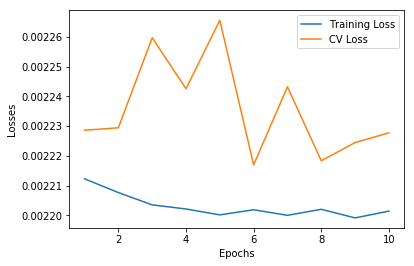

,dropout,emb_dim,hidden_dim,lr,lr_decay,momentum,name,nonlinearity,num_layers,weight_decay,epochs_trained,train_loss_min,cv_loss_min,training_time,remarks
5,0.250959,200,300,0.045527,"(3, 0.9)",0.8,rnn_006,tanh,2,2.120199e-07,10,0.002201,0.002228,12.343685,poor


In [66]:
def plot_losses(model_info):
    num_epochs = len(model_info['epoch_train_losses'])
    epochs = np.arange(num_epochs) + 1
    plt.plot(epochs, model_info['epoch_train_losses'], label='Training Loss')
    plt.plot(epochs, model_info['epoch_cv_losses'], label='CV Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.show()

model_info_dict = {m['name']: model_info[i] for i, m in enumerate(hp_config['model_params'])}
m = 'rnn_006'
plot_losses(model_info_dict[m])
model_params_df[model_params_df['name'] == m]

In [74]:
filtered = model_params_df[['name', 'lr', 'hidden_dim', 'dropout', 'nonlinearity', 'weight_decay', 
                 'momentum', 'train_loss_min', 'cv_loss_min', 'remarks']]
filtered[filtered['remarks'] == 'poor']
filtered[filtered['lr'] > 0.3]

,name,lr,hidden_dim,dropout,nonlinearity,weight_decay,momentum,train_loss_min,cv_loss_min,remarks
2,rnn_003,0.315522,150,0.213156,tanh,3.313043e-11,0.97,0.007829,0.007959,poor
9,rnn_010,0.500000,150,0.104790,tanh,1.000000e-05,0.97,0.007721,0.008060,poor
10,rnn_011,0.500000,150,0.166471,tanh,1.000000e-05,0.97,0.008336,0.008654,poor
17,rnn_018,0.500000,150,0.077831,tanh,6.842562e-07,0.80,0.002206,0.002223,ok
18,rnn_019,0.500000,400,0.371150,tanh,2.303622e-06,0.80,0.002226,0.002250,meh
19,rnn_020,0.500000,400,0.325256,relu,1.000000e-05,0.97,0.002216,0.002259,poor
